In [5]:
#!pip install lime

In [1]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

# Modelling
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC

#Lime-local interpretable model-agnostic explanations
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
sns.set(font_scale=1.3)
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laxmi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\laxmi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
# Read datasets
df_train = pd.read_csv('train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('test.txt', names=['Text', 'Emotion'], sep=';')

In [6]:
df_train.head()

Text  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger

In [7]:
print(df_train.shape)

(16000, 2)


In [8]:
df_test.head()

Text  Emotion
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i left with my bouquet of red and yellow tulip...      joy
4    i was feeling a little vain when i did this one  sadness

In [9]:
print(df_test.shape)

(2000, 2)


In [10]:
df_val.head()

Text  Emotion
0  im feeling quite sad and sorry for myself but ...  sadness
1  i feel like i am still looking at a blank canv...  sadness
2                     i feel like a faithful servant     love
3                  i am just feeling cranky and blue    anger
4  i can have for a treat or if i am feeling festive      joy

In [11]:
print(df_val.shape)

(2000, 2)


In [12]:
df_train.Emotion.value_counts()

Emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [13]:
df_train.Emotion.value_counts() / df_train.shape[0] *100

Emotion
joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: count, dtype: float64

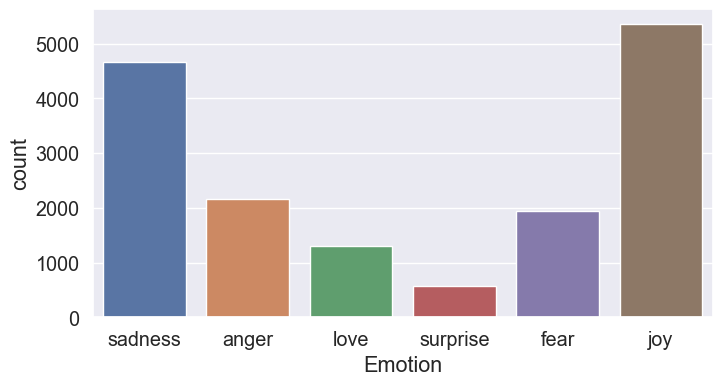

In [14]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_train);

In [15]:
df_train.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [16]:
df_train.duplicated().sum()

1

In [17]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [18]:
df_train[df_train['Text'].duplicated() == True]

Text   Emotion
5067   i feel on the verge of tears from weariness i ...       joy
6133               i still feel a craving for sweet food      love
6563   i tend to stop breathing when i m feeling stre...     anger
7623   i was intensely conscious of how much cash i h...   sadness
7685   im still not sure why reilly feels the need to...  surprise
8246   i am not amazing or great at photography but i...      love
9596   ive also made it with both sugar measurements ...       joy
9687   i had to choose the sleek and smoother feel of...       joy
9769   i often find myself feeling assaulted by a mul...   sadness
9786        i feel im being generous with that statement       joy
10117  i feel pretty tortured because i work a job an...      fear
10581                       i feel most passionate about       joy
11273  i was so stubborn and that it took you getting...       joy
11354  i write these words i feel sweet baby kicks fr...      love
11525  i feel a remembrance of the strange by justin ...      fear
11823  i have chose for myself that makes me feel ama...       joy
12441                   i still feel completely accepted      love
12562                           i feel so weird about it  surprise
12892  i cant escape the tears of sadness and just tr...       joy
13236   i feel like a tortured artist when i talk to her     anger
13879  i feel like i am very passionate about youtube...      love
14106                             i feel kind of strange  surprise
14313    i could feel myself hit this strange foggy wall  surprise
14633  i feel pretty weird blogging about deodorant b...      fear
14925  i resorted to yesterday the post peak day of i...      fear
15314  i will feel as though i am accepted by as well...       joy
15328  i shy away from songs that talk about how i fe...       joy
15571  i bet taylor swift basks in the knowledge that...     anger
15704  i began to feel accepted by gaia on her own terms       joy
15875  i was sitting in the corner stewing in my own ...     anger

In [19]:
df_train[df_train['Text'] == df_train.iloc[7623]['Text']]

Text  Emotion
1625  i was intensely conscious of how much cash i h...    anger
7623  i was intensely conscious of how much cash i h...  sadness

In [20]:
df_train[df_train['Text'] == df_train.iloc[14313]['Text']]

Text   Emotion
13653  i could feel myself hit this strange foggy wall      fear
14313  i could feel myself hit this strange foggy wall  surprise

In [21]:
df_train[df_train['Text'] == df_train.iloc[13879]['Text']]

Text Emotion
7333   i feel like i am very passionate about youtube...     joy
13879  i feel like i am very passionate about youtube...    love

In [22]:
#removing duplicated text
index = df_train[df_train['Text'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [23]:
#Count the number of stopwords in the data
temp =df_train.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

stop_words
5     1416
7     1405
6     1392
4     1341
8     1319
3     1263
9     1177
10    1048
2      922
11     889
12     752
13     644
14     493
1      450
15     376
16     265
17     238
18     164
19     113
20      90
0       79
21      60
22      33
23      19
24       7
25       6
26       6
28       1
29       1
Name: count, dtype: int64

In [24]:
df_test.Emotion.value_counts()

Emotion
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

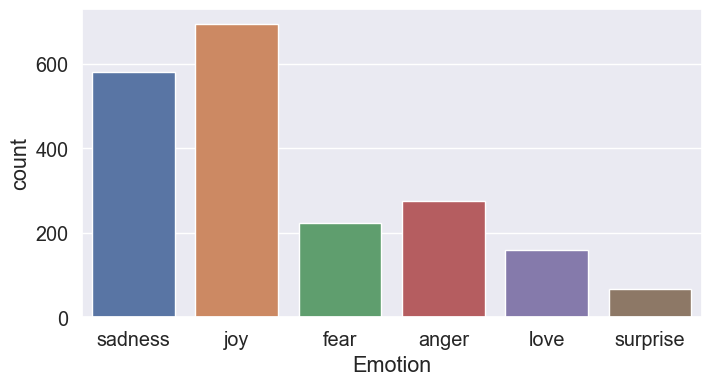

In [25]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_test);

In [26]:
df_test.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [27]:
df_test.duplicated().sum()

0

In [28]:
df_test[df_test['Text'].duplicated() == True]

Empty DataFrame
Columns: [Text, Emotion]
Index: []

In [29]:
#Count the number of stopwords in the data
temp =df_test.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

stop_words
7     184
6     179
3     175
5     175
4     163
9     163
8     139
10    123
2     118
11    115
12     84
13     71
15     61
14     58
1      42
16     40
17     31
18     22
20     17
19     11
21     10
0       8
23      7
24      2
22      2
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

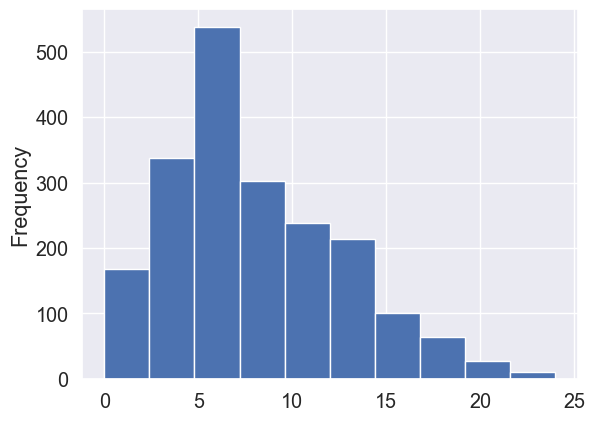

In [30]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist')

In [31]:
df_val.Emotion.value_counts()

Emotion
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64

In [32]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_val);

In [33]:
df_val.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [34]:
df_val.duplicated().sum()

0

In [35]:
df_val[df_val['Text'].duplicated() == True]

Text Emotion
603   i have had several new members tell me how com...     joy
1993                           i feel so tortured by it   anger

In [36]:
df_val[df_val['Text'] == df_val.iloc[603]['Text']]

Text Emotion
300  i have had several new members tell me how com...    love
603  i have had several new members tell me how com...     joy

In [37]:
df_val[df_val['Text'] == df_val.iloc[1993]['Text']]

Text Emotion
774   i feel so tortured by it    fear
1993  i feel so tortured by it   anger

In [38]:
#removing duplicated text
index = df_val[df_val['Text'].duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [39]:
#Count the number of stopwords in the data
temp =df_val.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()[:10]

stop_words
7     190
5     175
8     173
6     160
3     160
10    150
9     146
4     145
2     133
11    103
Name: count, dtype: int64

In [40]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist');

In [41]:
def dataframe_difference(df1, df2, which=None):
    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
    return diff_df

In [42]:
dataframe_difference(df_train, df_test, which='both')

Empty DataFrame
Columns: [Text, Emotion, _merge]
Index: []

In [43]:
dataframe_difference(df_train, df_val, which='both')

Empty DataFrame
Columns: [Text, Emotion, _merge]
Index: []

In [44]:
dataframe_difference(df_val, df_test, which='both')

Empty DataFrame
Columns: [Text, Emotion, _merge]
Index: []

In [45]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()
    text = text.split()
    text=[lemmatizer.lemmatize(y) for y in text]
    return " " .join(text)

def remove_stop_words(text):
    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    text = text.split()
    text=[y.lower() for y in text]
    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan

def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : Removing_numbers(text))
    df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
    df.Text=df.Text.apply(lambda text : Removing_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

In [46]:
#nltk.download('wordnet')

In [47]:
normalized_sentence("My Name is Mohamed. @Tweets,  plays 2022  Egypt_")

'name mohamed tweet play egypt'

In [48]:
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)

In [49]:
X_train = df_train['Text'].values
y_train = df_train['Emotion'].values

X_test = df_test['Text'].values
y_test = df_test['Emotion'].values

X_val = df_val['Text'].values
y_val = df_val['Emotion'].values

In [50]:
def train_model(model, data, targets):
    # Create a Pipeline object with a TfidfVectorizer and the given model
    text_clf = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', model)])
    # Fit the model on the data and targets
    text_clf.fit(data, targets)
    return text_clf

In [51]:
def get_F1(trained_model,X,y):
    # Make predictions on the input data using the trained model
    predicted=trained_model.predict(X)
    # Calculate the F1 score for the predictions
    f1=f1_score(y,predicted, average=None)
    # Return the F1 score
    return f1

In [52]:
#Train the model with the training data
log_reg = train_model(LogisticRegression(solver='liblinear',random_state = 0), X_train, y_train)

In [53]:
#Make a single prediction
y_pred=log_reg.predict(['Happy'])
y_pred

array(['joy'], dtype=object)

In [54]:
#test the model with the test data
y_pred=log_reg.predict(X_test)

#calculate the accuracy
log_reg_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', log_reg_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(log_reg,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score'])

Accuracy:  0.8685 



F1 score
sadness   0.858223
anger     0.823810
love      0.893048
surprise  0.703704
fear      0.915683
joy       0.626263

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.89      0.83      0.86       275
        fear       0.88      0.77      0.82       224
         joy       0.83      0.96      0.89       695
        love       0.86      0.60      0.70       159
     sadness       0.90      0.93      0.92       581
    surprise       0.94      0.47      0.63        66

    accuracy                           0.87      2000
   macro avg       0.88      0.76      0.80      2000
weighted avg       0.87      0.87      0.86      2000



In [56]:
#Train the model with the training data
DT = train_model(DecisionTreeClassifier(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=DT.predict(X_test)

#calculate the accuracy
DT_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', DT_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(DT,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score'])

Accuracy:  0.859 



F1 score
sadness   0.873440
anger     0.798206
love      0.890671
surprise  0.737805
fear      0.900605
joy       0.617647

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.86      0.89      0.87       275
        fear       0.80      0.79      0.80       224
         joy       0.90      0.88      0.89       695
        love       0.72      0.76      0.74       159
     sadness       0.90      0.90      0.90       581
    surprise       0.60      0.64      0.62        66

    accuracy                           0.86      2000
   macro avg       0.80      0.81      0.80      2000
weighted avg       0.86      0.86      0.86      2000



In [58]:
#Train the model with the training data
SVM = train_model(SVC(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=SVM.predict(X_test)

#calculate the accuracy
SVM_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', SVM_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(SVM,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score'])

Accuracy:  0.8675 



F1 score
sadness   0.857685
anger     0.827907
love      0.893645
surprise  0.681648
fear      0.914821
joy       0.654206

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.90      0.82      0.86       275
        fear       0.86      0.79      0.83       224
         joy       0.83      0.96      0.89       695
        love       0.84      0.57      0.68       159
     sadness       0.91      0.92      0.91       581
    surprise       0.85      0.53      0.65        66

    accuracy                           0.87      2000
   macro avg       0.87      0.77      0.80      2000
weighted avg       0.87      0.87      0.86      2000



In [60]:
#Train the model with the training data
RF = train_model(RandomForestClassifier(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=RF.predict(X_test)

#calculate the accuracy
RF_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', RF_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(RF, X_test, y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score'])

Accuracy:  0.8895 



F1 score
sadness   0.903811
anger     0.868421
love      0.908199
surprise  0.738983
fear      0.933798
joy       0.634146

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.90      0.91      0.90       275
        fear       0.85      0.88      0.87       224
         joy       0.89      0.93      0.91       695
        love       0.80      0.69      0.74       159
     sadness       0.95      0.92      0.93       581
    surprise       0.68      0.59      0.63        66

    accuracy                           0.89      2000
   macro avg       0.85      0.82      0.83      2000
weighted avg       0.89      0.89      0.89      2000



In [62]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree','Support Vector Machine','Random Forest'],
    'Accuracy': [log_reg_accuracy.round(2), DT_accuracy.round(2), SVM_accuracy.round(2), RF_accuracy.round(2)]})

models.sort_values(by='Accuracy', ascending=False).reset_index().drop(['index'], axis=1)

Model  Accuracy
0           Random Forest      0.89
1     Logistic Regression      0.87
2  Support Vector Machine      0.87
3           Decision Tree      0.86

In [63]:
explainer_LR = LimeTextExplainer(class_names=RF.classes_)
idx  = 15
print("Actual Text : ", X_test[idx])
print("Prediction : ", RF.predict(X_test)[idx])
exp = explainer_LR.explain_instance(X_test[idx], RF.predict_proba,top_labels=5)
exp.show_in_notebook()

Actual Text :  feeling heartbroken im sure katniss
Prediction :  sadness


In [64]:
explainer_LR = LimeTextExplainer(class_names=RF.classes_)
idx  = 5
print("Actual Text : ", X_test[idx])
print("Prediction : ", RF.predict(X_test)[idx])
exp = explainer_LR.explain_instance(X_test[idx], RF.predict_proba,top_labels=5)
exp.show_in_notebook()

Actual Text :  cant walk shop anywhere feel uncomfortable
Prediction :  fear


In [65]:
#Make a single prediction
y_pred=log_reg.predict(['The loss of a loved one left me feeling empty and drained'])
y_pred

array(['sadness'], dtype=object)

In [66]:
#Make a single prediction
y_pred=log_reg.predict(['I couldnt stop smiling when I saw my newborn baby for the first time'])
y_pred

array(['joy'], dtype=object)

In [67]:
y_pred=log_reg.predict(['i am feeling outraged it shows everywhere'])
y_pred

array(['anger'], dtype=object)

In [68]:
y_pred=log_reg.predict(['I feel a little nervous i go to the gym'])
y_pred

array(['fear'], dtype=object)

In [69]:
y_pred=log_reg.predict(['I want each of you to feel my gentle embrace'])
y_pred

array(['love'], dtype=object)

In [70]:
y_pred=log_reg.predict(['i love and captured an atmospheric feeling in their landscapes that really impressed me'])
y_pred

array(['surprise'], dtype=object)

In [72]:
from sklearn.feature_extraction.text import CountVectorizer

In [73]:
pipe_rf = Pipeline(steps=[('cv',CountVectorizer()),('RF', RandomForestClassifier())])
pipe_rf.fit(X_train,y_train)
pipe_rf.score(X_test,y_test)

0.889

In [74]:
from sklearn.pipeline import Pipeline
import joblib
model_path = 'C:/Users/laxmi/Sravani/project1/EmotionDetection.pkl'
joblib.dump(pipe_rf, model_path)
print(f"Model saved to {model_path}")

Model saved to C:/Users/laxmi/Sravani/project1/EmotionDetection.pkl


In [75]:
#!pip install scikit-learn

In [76]:
example_data = ["I am feeling great today!", "This is a bad day."]
model=joblib.load(model_path)
predictions = model.predict(example_data)
print(predictions)

['joy' 'sadness']
